In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [47]:
# --- Configuración ---
batch_size = 64
epochs = 5
iterations = 3
prune_percentages = [80, 70, 60, 50, 40, 30, 20, 15, 10, 8, 5, 3]
data_path = './animals10'

#cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_path, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_path, "test"), transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [49]:
def get_alexnet_model():
    model = models.alexnet(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 10)  # Animals-10 tiene 10 clases
    return model

In [50]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [51]:
def train_model(model, dataloader, criterion, optimizer, iteration, epochs=5):
    model.train()
    accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        acc = evaluate_model(model, test_loader)
        accuracies.append(acc)

    print(f'Accuracy: {max(accuracies):.2%}')
    return total_loss / len(dataloader), accuracies

In [52]:
import numpy as np

def create_prune_mask(model, prune_percentage=0.2):
    all_weights = []

    # Extraer todos los pesos relevantes
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            all_weights.append(param.data.cpu().numpy().flatten())  # mover a CPU y flatten

    # Concatenar todos los pesos en un array plano
    all_weights = np.concatenate(all_weights)

    # Calcular percentil global
    threshold = np.percentile(np.abs(all_weights), 100 * (1 - prune_percentage))

    # Crear máscara por capa
    mask = {}
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            mask[name] = (param.abs() > threshold).float().to(device)

    return mask

def prune_model(model, mask):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask:
                param.data *= mask[name]

def count_zero_weights(model):
    total_weights = 0
    zero_weights = 0
    for param in model.parameters():
        if param.requires_grad:
            total_weights += param.numel()
            zero_weights += (param.data == 0).sum().item()
    return zero_weights, total_weights

In [53]:
results = {}

# Crear modelo base y sus copias
model = get_alexnet_model().to(device)
model_entrenado = get_alexnet_model().to(device)
model_inicial = model.state_dict()  # Guardar pesos iniciales

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def run_experiment():
    global results
    print(f"===== Entrenamiento del modelo original =====")

    # Re-crear modelo y optimizador limpio cada vez
    model = get_alexnet_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model_inicial = model.state_dict()

    _, accuracies_original = train_model(model, train_loader, criterion, optimizer, 0, epochs)
    print(f"📈 Final accuracies for original model: {accuracies_original}")
    results[100] = {"accuracies": accuracies_original}

    for prune_percentage in prune_percentages:
        print(f"\n===== Pruning al {prune_percentage}% =====")

        model.load_state_dict(model_inicial)  # Resetear pesos
        accuracies_pruned = []

        for iteration in range(1, iterations + 1):
            print(f"\n→ Iteración {iteration}/{iterations}")

            prune_mask = create_prune_mask(model_entrenado, prune_percentage / 100.0)
            prune_model(model, prune_mask)

            zero_weights, total_weights = count_zero_weights(model)
            print(f"🔍 Antes de entrenar: Zero = {zero_weights}, Total = {total_weights}, "
                  f"Porcentaje = {100 * zero_weights / total_weights:.2f}%")

            optimizer = optim.Adam(model.parameters(), lr=0.001)  # Nuevo optimizador
            _, accuracies = train_model(model, train_loader, criterion, optimizer, iteration, epochs)

            zero_weights, total_weights = count_zero_weights(model)
            print(f"📊 Después de entrenar: Zero = {zero_weights}, Total = {total_weights}, "
                  f"Porcentaje = {100 * zero_weights / total_weights:.2f}%")

            accuracies_pruned.extend(accuracies)

        results[prune_percentage] = {"accuracies": accuracies_pruned}
        print(f"✅ Final accuracies for {prune_percentage}% pruning: {accuracies_pruned}")


# --- Ejecutar ---
start = time.time()
run_experiment()
end = time.time()

print(f"\n⏱️ Tiempo total de ejecución: {end - start:.2f} segundos")

===== Entrenamiento del modelo original =====
Accuracy: 18.57%
📈 Final accuracies for original model: [0.18565159320740315, 0.18565159320740315, 0.1841251669528716, 0.1841251669528716, 0.18565159320740315]

===== Pruning al 80% =====

→ Iteración 1/3
🔍 Antes de entrenar: Zero = 11407096, Total = 57044810, Porcentaje = 20.00%
Accuracy: 49.78%
📊 Después de entrenar: Zero = 9793191, Total = 57044810, Porcentaje = 17.17%

→ Iteración 2/3
🔍 Antes de entrenar: Zero = 11407096, Total = 57044810, Porcentaje = 20.00%
Accuracy: 58.10%
📊 Después de entrenar: Zero = 10572101, Total = 57044810, Porcentaje = 18.53%

→ Iteración 3/3
🔍 Antes de entrenar: Zero = 11407096, Total = 57044810, Porcentaje = 20.00%
Accuracy: 60.64%
📊 Después de entrenar: Zero = 10360055, Total = 57044810, Porcentaje = 18.16%
✅ Final accuracies for 80% pruning: [0.24480061057050181, 0.34478153024232017, 0.3928639572600649, 0.4127074985689754, 0.4978057622591109, 0.5199389429498187, 0.5540927303949628, 0.5586720091585575, 0.57

In [54]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

03:04:21.83


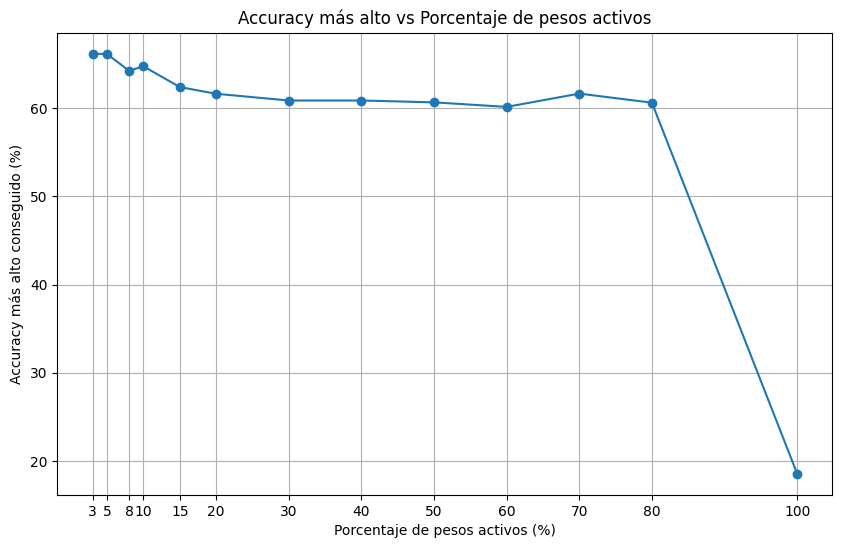

In [55]:
def extract_best_accuracies(results):
    best_accuracies = []
    pruning_percentages = []
    for percentage, data in results.items():
        pruning_percentages.append(percentage)
        best_accuracy = max(data["accuracies"])
        best_accuracies.append(best_accuracy)
    return pruning_percentages, best_accuracies

pruning_percentages, best_accuracies = extract_best_accuracies(results)

plt.figure(figsize=(10, 6))
plt.plot(pruning_percentages, [acc * 100 for acc in best_accuracies], marker='o')
plt.title('Accuracy más alto vs Porcentaje de pesos activos')
plt.xlabel('Porcentaje de pesos activos (%)')
plt.ylabel('Accuracy más alto conseguido (%)')
plt.grid(True)
plt.xticks(pruning_percentages)
plt.show()